In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, TreeSearch, BDeuScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.independencies import IndependenceAssertion


df = pd.read_csv("US_Accidents_March23.csv")
print(f'dfset contains {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

dfset contains 7728394 rows and 46 columns


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [4]:
print(len(df.columns))
df.columns

46


Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [5]:
df.drop(['ID', 'Source', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Description', 'Street', 'City', 'County', 'Zipcode', 
           'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Wind_Direction', 'Amenity', 'Bump', 'Give_Way', 'No_Exit', 'Railway', 'Distance(mi)',
           'Roundabout', 'Station', 'Traffic_Calming', 'Turning_Loop', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Pressure(in)', 'Wind_Chill(F)'], axis=1, inplace=True)

df.dropna(inplace=True)

In [6]:
data = df.copy(deep=True)

In [7]:
df.columns

Index(['Severity', 'State', 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Crossing',
       'Junction', 'Stop', 'Traffic_Signal', 'Sunrise_Sunset'],
      dtype='object')

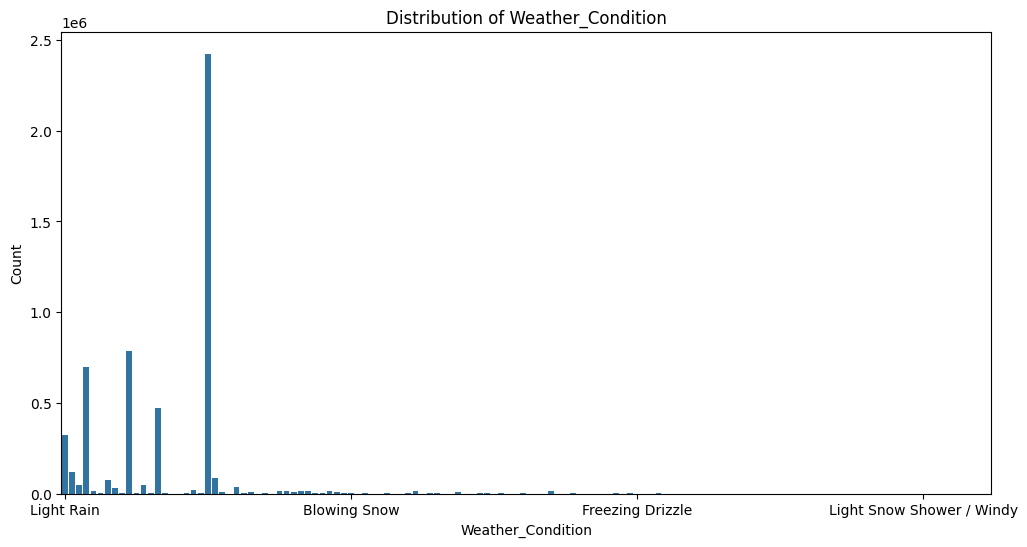

In [8]:
cols_to_discretize = [
    # 'Wind_Speed(mph)',
    'Weather_Condition',
]

for col in cols_to_discretize:
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(x=data[col])
    ticks = ax.get_xticks()
    ax.set_xticks(ticks[::40])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

**Temperature(F)**

- -45 = Cold
- 45-80 = Mild
- 80+ = Hot

**Visibility(mi)**

- -3.0 = Low visibility
- 3.0 - 7.0 = Moderate visibility
- 7.0+ = High visibility

**Wind speed(mph)**

- 0 - 10.0 = Low wind speed
- 10.0 - 25.0 = Moderate wind speed
- 25.0+ = High wind speed

**Precipitation(in)**

- 0 - 0.005 = Low precipitation
- 0.005 - 0.3 = Moderate precipitation
- 0.3 = High precipitation


In [9]:
# Equal-Width Binning (era meglio Quantile-Based Discretization ???)
discrete_bins = 3

cols_to_discretize = [
     'Humidity(%)', 
]

for col in cols_to_discretize:
    min_val = data[col].min()
    max_val = data[col].max()
    # Creazione dei bin con ampiezza fissa
    bins = pd.cut(data[col], bins=np.linspace(min_val, max_val, discrete_bins+1), include_lowest=True)
    print(f"{col} -> {bins.dtype.categories}")
    bin2int = {x: i for i, x in enumerate(bins.dtype.categories)}
    data[col] = bins.apply(lambda x: bin2int[x]).astype(np.uint8)


#Discretize Temperature
bins = [-float('inf'), 45, 80, float('inf')]  # Intervalli
labels = [1, 2, 3]  # Etichette corrispondenti
data['Temperature(F)'] = pd.cut(data['Temperature(F)'], bins=bins, labels=labels)

#Discretize Visibility
bins = [-float('inf'), 3.0, 7.0, float('inf')]
labels = [1, 2, 3]
data['Visibility(mi)'] = pd.cut(data['Visibility(mi)'], bins=bins, labels=labels)

#Discretize Wind speed
bins = [-float('inf'), 10.0, 25.0, float('inf')]
labels = [1, 2, 3]
data['Wind_Speed(mph)'] = pd.cut(data['Wind_Speed(mph)'], bins=bins, labels=labels)

#Discretize Precipitation
bins = [-float('inf'), 0.005, 0.3, float('inf')]
labels = [1, 2, 3]
data['Precipitation(in)'] = pd.cut(data['Precipitation(in)'], bins=bins, labels=labels)

# # Mostriamo il risultato
# plt.figure(figsize=(12, 6))
# ax = sns.countplot(x=data['Precipitation(in)'])
# ticks = ax.get_xticks()
# ax.set_xticks(ticks[::50])
# plt.title(f'Distribution of wind speed')
# plt.xlabel('Precipitation(in)')
# plt.ylabel('Count')
# plt.show()


Humidity(%) -> IntervalIndex([(0.999, 34.0], (34.0, 67.0], (67.0, 100.0]], dtype='interval[float64, right]')


In [10]:
data.describe(include='all')

,Severity,State,Temperature(F),Humidity(%),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Crossing,Junction,Stop,Traffic_Signal,Sunrise_Sunset
count,5.374832e+06,5374832,5374832.0,5.374832e+06,5374832.0,5374832.0,5374832.0,5374832,5374832,5374832,5374832,5374832,5374832
unique,NaN,49,3.0,NaN,3.0,3.0,3.0,130,2,2,2,2,2
top,NaN,CA,2.0,NaN,3.0,1.0,1.0,Fair,False,False,False,False,Day
freq,NaN,1146356,3396125.0,NaN,4510255.0,4119409.0,4868498.0,2424538,4792311,5003041,5227113,4673904,3646926
mean,2.155319e+00,NaN,NaN,1.395643e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.498935e-01,NaN,NaN,6.831676e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000e+00,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.000000e+00,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.000000e+00,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.000000e+00,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5374832 entries, 5 to 7728393
Data columns (total 13 columns):
 #   Column             Dtype   
---  ------             -----   
 0   Severity           int64   
 1   State              object  
 2   Temperature(F)     category
 3   Humidity(%)        uint8   
 4   Visibility(mi)     category
 5   Wind_Speed(mph)    category
 6   Precipitation(in)  category
 7   Weather_Condition  object  
 8   Crossing           bool    
 9   Junction           bool    
 10  Stop               bool    
 11  Traffic_Signal     bool    
 12  Sunrise_Sunset     object  
dtypes: bool(4), category(4), int64(1), object(3), uint8(1)
memory usage: 251.2+ MB


In [12]:
data.head()

,Severity,State,Temperature(F),Humidity(%),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Crossing,Junction,Stop,Traffic_Signal,Sunrise_Sunset
5,3,OH,1,2,2,1,2,Light Rain,False,False,False,False,Day
9,3,OH,1,2,1,1,2,Light Rain,False,False,False,False,Day
11,3,OH,1,2,1,1,2,Light Rain,False,False,False,False,Day
14,2,OH,1,2,1,1,2,Light Rain,False,False,False,True,Day
20,2,OH,1,2,1,1,2,Light Snow,False,False,False,False,Day


### Custom model

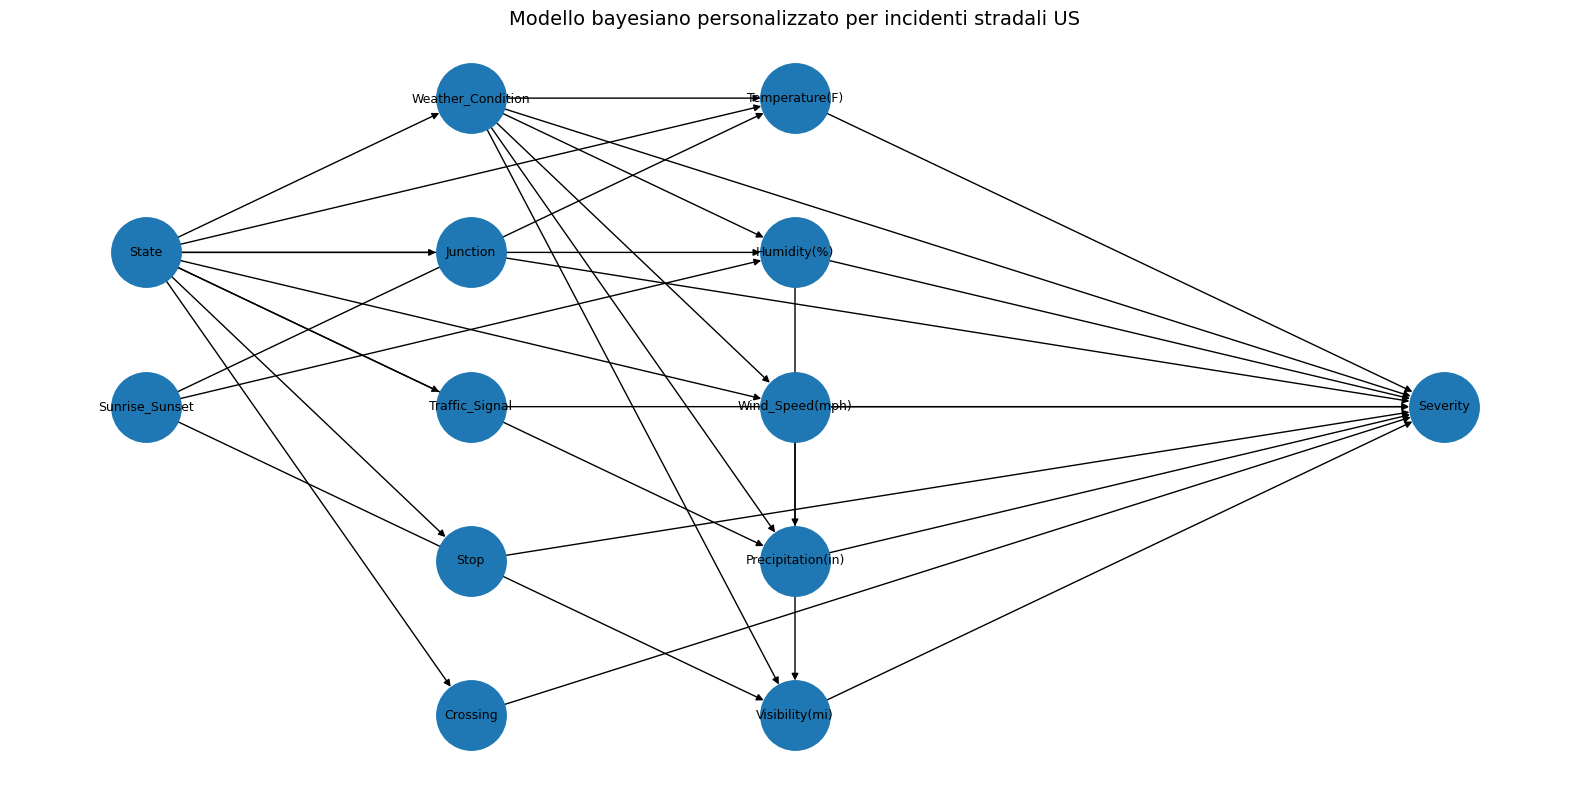

In [13]:
# Definizione del modello bayesiano con relazioni personalizzate
custom_model = BayesianModel([
    # Relazioni legate allo stato e all'ambiente
    ('State', 'Weather_Condition'),
    ('State', 'Junction'),
    ('State', 'Traffic_Signal'),
    ('State', 'Stop'),
    ('State', 'Crossing'),
    ('State', 'Temperature(F)'),
    ('State', 'Humidity(%)'),
    ('State', 'Wind_Speed(mph)'),
    ('State', 'Precipitation(in)'),

    ('Weather_Condition', 'Temperature(F)'),
    ('Weather_Condition', 'Humidity(%)'),
    ('Weather_Condition', 'Wind_Speed(mph)'),
    ('Weather_Condition', 'Precipitation(in)'),
    ('Weather_Condition', 'Visibility(mi)'),
    
    ('Wind_Speed(mph)', 'Visibility(mi)'),
    
    # Influenza di Sunrise_Sunset sulla visibilità
    ('Sunrise_Sunset', 'Visibility(mi)'),
    ('Sunrise_Sunset', 'Temperature(F)'),
    ('Sunrise_Sunset', 'Humidity(%)'),

    ('Weather_Condition', 'Severity'),
    

    ('Humidity(%)', 'Precipitation(in)'),
    
    
    
    # Fattori infrastrutturali e ambientali che influenzano la gravità dell'incidente
    ('Junction', 'Severity'),
    ('Traffic_Signal', 'Severity'),
    ('Stop', 'Severity'),
    ('Crossing', 'Severity'),
    ('Precipitation(in)', 'Severity'),
    ('Visibility(mi)', 'Severity'),
    
    ('Temperature(F)', 'Severity'),
    ('Humidity(%)', 'Severity'),

    ('Wind_Speed(mph)', 'Severity'),
])

# Posizioni dei nodi su una griglia a colonne
pos = {
    # Column 1: Basic factors
    'State': (0, 0),
    'Sunrise_Sunset': (0, -1),

    # Column 2: Environmental signals and junction-related factors
    'Weather_Condition': (2, 1),
    'Junction': (2, 0),
    'Traffic_Signal': (2, -1),
    'Stop': (2, -2),
    'Crossing': (2, -3),

    # Column 3: Weather measurements
    'Temperature(F)': (4, 1),
    'Humidity(%)': (4, 0),
    'Wind_Speed(mph)': (4, -1),
    'Precipitation(in)': (4, -2),
    'Visibility(mi)': (4, -3),
    
    # Column 5: Outcome
    'Severity': (8, -1)
}

# Creazione della figura e disegno del grafo
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
nx.draw_networkx(
    custom_model,
    pos=pos,
    ax=ax,
    node_size=2500,
    font_size=9,
    arrows=True
)

ax.set_title('Modello bayesiano personalizzato per incidenti stradali US', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# import io
# import sys

# # Reset learned CPDs and refit the model
# custom_model.cpds = []
# custom_model.fit(data)

# from pgmpy.factors.discrete.CPD import TabularCPD

# def print_full(cpd):
#     backup = TabularCPD._truncate_strtable
#     TabularCPD._truncate_strtable = lambda self, x: x
#     print(cpd)
#     TabularCPD._truncate_strtable = backup

# # Capture printed output using StringIO
# old_stdout = sys.stdout
# sys.stdout = mystdout = io.StringIO()

# # Print all the learned CPTs
# for cpd in custom_model.get_cpds():
#     print('CPT of {}'.format(cpd.variable))
#     print_full(cpd)
#     print('\n')

# # Restore original stdout
# sys.stdout = old_stdout

# # Save captured output to a file
# with open('CPDs.txt', 'w', encoding='utf-8') as file:
#     file.write(mystdout.getvalue())

Building tree:   0%|          | 0/78.0 [00:00<?, ?it/s]

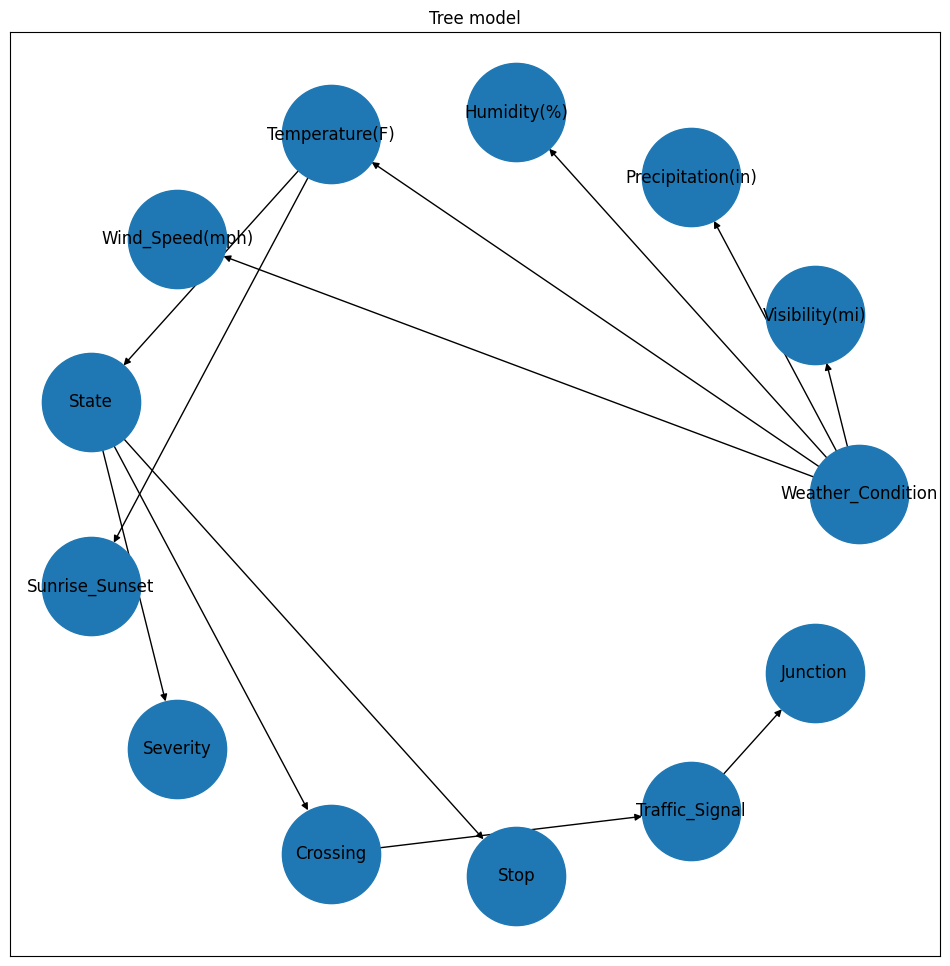

In [15]:
# ts = TreeSearch(data=data, root_node='State')
ts = TreeSearch(data=data)
tree_model = ts.estimate()

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=5000)
# fig.savefig('tree')
ax.set_title('Tree model')
tree_model = BayesianModel(tree_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

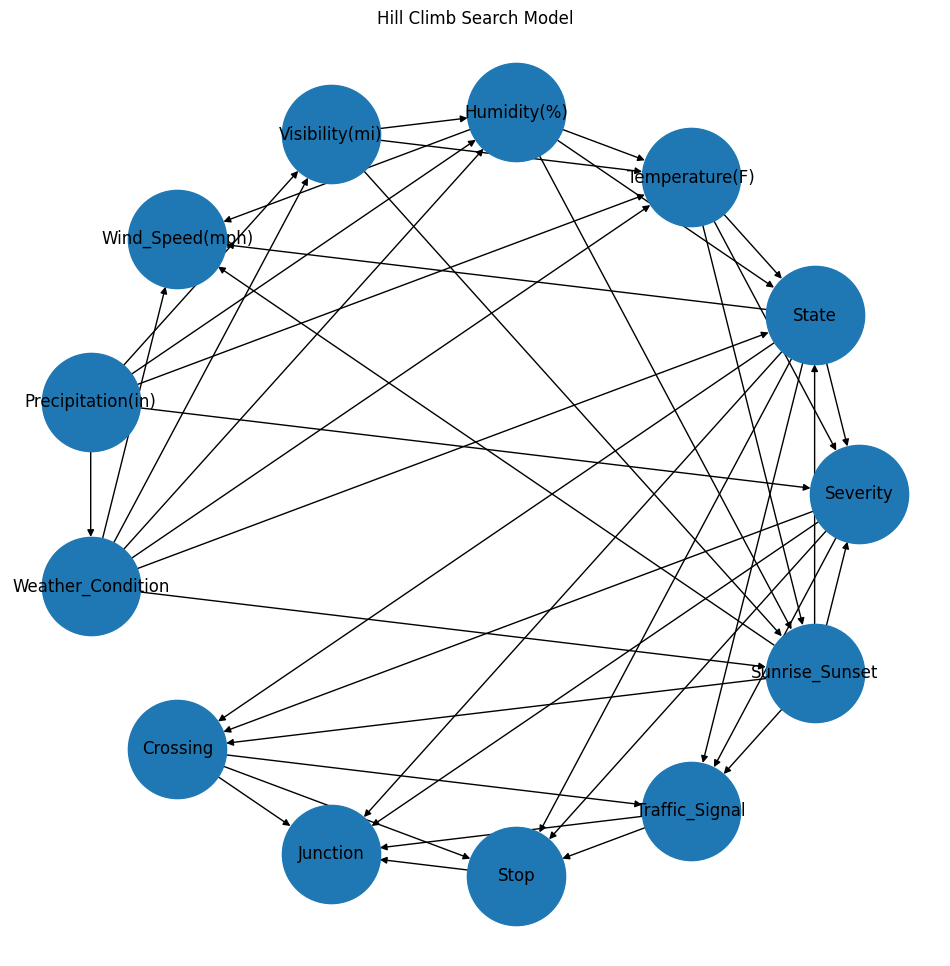

In [16]:

scorer = BDeuScore(data=data)


hc = HillClimbSearch(data=data)


hc_model = hc.estimate(scoring_method=scorer)


plt.figure(figsize=(12, 12))
pos_hc = nx.drawing.layout.circular_layout(hc_model)
nx.draw_networkx(hc_model, pos=pos_hc, node_size=5000, with_labels=True, arrows=True)
plt.title('Hill Climb Search Model')
plt.axis('off')
plt.show()

hc_model_bayes = BayesianModel(hc_model.edges())

### Learning the CPDs

In [17]:
models = [('custom', custom_model), ('tree', tree_model), ('hc', hc_model_bayes)]
for name, model in models:
    print(f'Computing CPDs for {name} model')
    model.fit(data, estimator=MaximumLikelihoodEstimator)

Computing CPDs for custom model
Computing CPDs for tree model
Computing CPDs for hc model


# Questions

In [25]:
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt

# Create inference objects for both models
infer_custom = VariableElimination(custom_model)
infer_tree = VariableElimination(tree_model)
infer_hc = VariableElimination(hc_model_bayes)





### Potential Queries to Explore

- **Extreme Weather & Severity:**  
    What is the probability of high-severity accidents given extreme weather conditions (e.g. high temperature combined with heavy precipitation)?

- **Combined Environmental Factors:**  
    How does the combination of low visibility and high wind speed influence accident severity?

- **Effect of Traffic Infrastructure:**  
    How does the presence of traffic signals or stop signs affect the severity distribution? Compare accidents occurring at intersections with and without these features.

- **Day vs. Night Analysis:**  
    Apart from the basic sunrise/sunset query, explore how severity is affected when combining day/night conditions with other factors such as weather conditions or state.

- **Regional Comparisons:**  
    Investigate if certain states or regions (e.g. comparing MA vs. MS) show significant differences in accident severity, and analyze what environmental factors could be driving those differences.


### QUERY 1

"What are the most dangerous temperatures for traveling?"

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

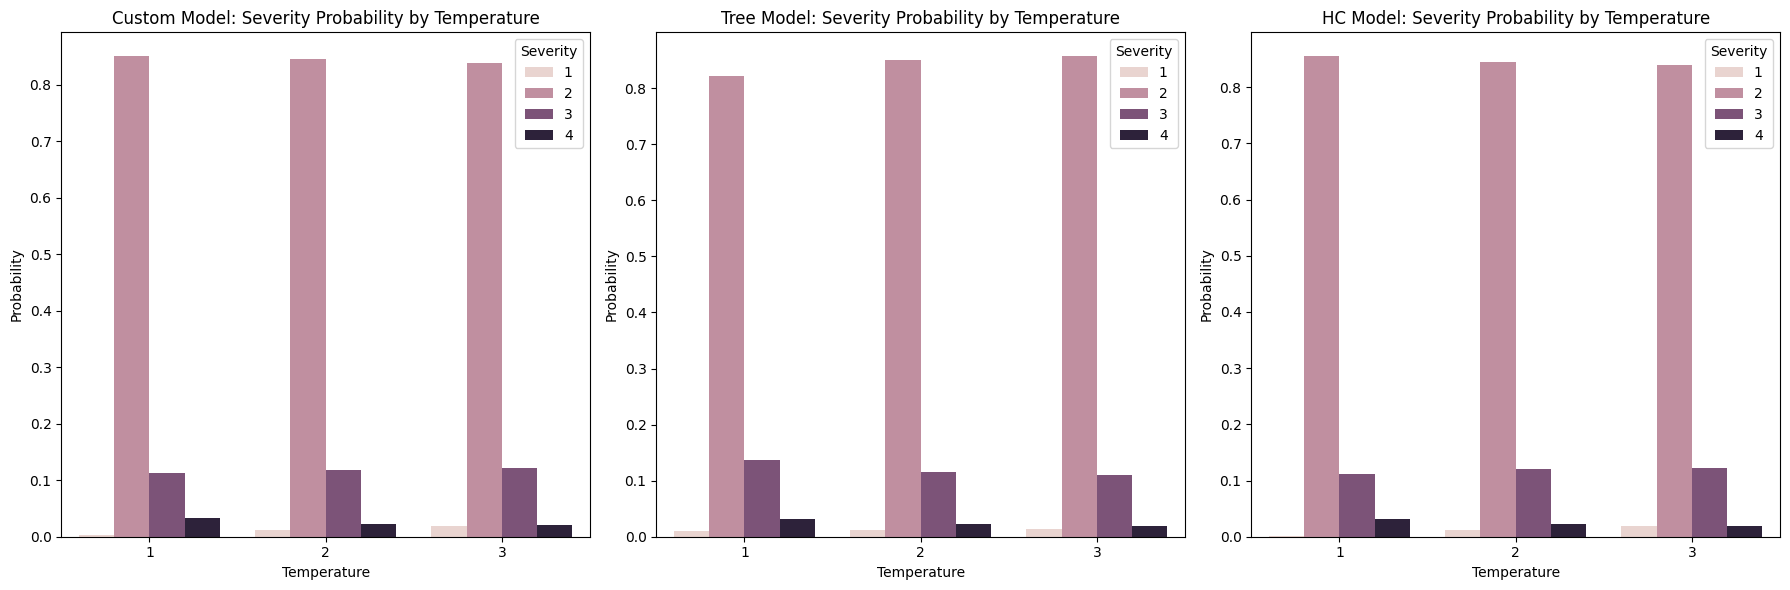

In [26]:
import seaborn as sns

# Define the range of temperatures to analyze
temperature_range = [1, 2, 3]  # Corresponding to Cold, Mild, Hot

# Initialize dictionaries to store results
severity_probs_custom = {}
severity_probs_tree = {}
severity_probs_hc = {}

# Perform the query for each temperature in the range
for temp in temperature_range:
    evidence = {'Temperature(F)': temp}
    
    # Query the custom model
    query_result_custom = infer_custom.query(variables=['Severity'], evidence=evidence)
    severity_probs_custom[temp] = query_result_custom.values
    
    # Query the tree model
    query_result_tree = infer_tree.query(variables=['Severity'], evidence=evidence)
    severity_probs_tree[temp] = query_result_tree.values

    # Query the hc model
    query_result_hc = infer_hc.query(variables=['Severity'], evidence=evidence)
    severity_probs_hc[temp] = query_result_hc.values
    

# Prepare data for seaborn
plot_data_custom = []
plot_data_tree = []
plot_data_hc = []

for temp, probs in severity_probs_custom.items():
    for severity, prob in zip([1, 2, 3, 4], probs):
        plot_data_custom.append({'Temperature': temp, 'Severity': severity, 'Probability': prob})

for temp, probs in severity_probs_tree.items():
    for severity, prob in zip([1, 2, 3, 4], probs):
        plot_data_tree.append({'Temperature': temp, 'Severity': severity, 'Probability': prob})

for temp, probs in severity_probs_hc.items():
    for severity, prob in zip([1, 2, 3, 4], probs):
        plot_data_hc.append({'Temperature': temp, 'Severity': severity, 'Probability': prob})

plot_df_custom = pd.DataFrame(plot_data_custom)
plot_df_tree = pd.DataFrame(plot_data_tree)
plot_df_hc = pd.DataFrame(plot_data_hc)

# Plot using seaborn with three subplots
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(data=plot_df_custom, x='Temperature', y='Probability', hue='Severity', ci=None)
plt.title("Custom Model: Severity Probability by Temperature")
plt.xlabel("Temperature")
plt.ylabel("Probability")
plt.legend(title="Severity")

plt.subplot(1, 3, 2)
sns.barplot(data=plot_df_tree, x='Temperature', y='Probability', hue='Severity', ci=None)
plt.title("Tree Model: Severity Probability by Temperature")
plt.xlabel("Temperature")
plt.ylabel("Probability")
plt.legend(title="Severity")

plt.subplot(1, 3, 3)
sns.barplot(data=plot_df_hc, x='Temperature', y='Probability', hue='Severity', ci=None)
plt.title("HC Model: Severity Probability by Temperature")
plt.xlabel("Temperature")
plt.ylabel("Probability")
plt.legend(title="Severity")

plt.tight_layout()
plt.show()


### QUERY 2

"how much is accidents' gravity conditioned by visibility?"

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

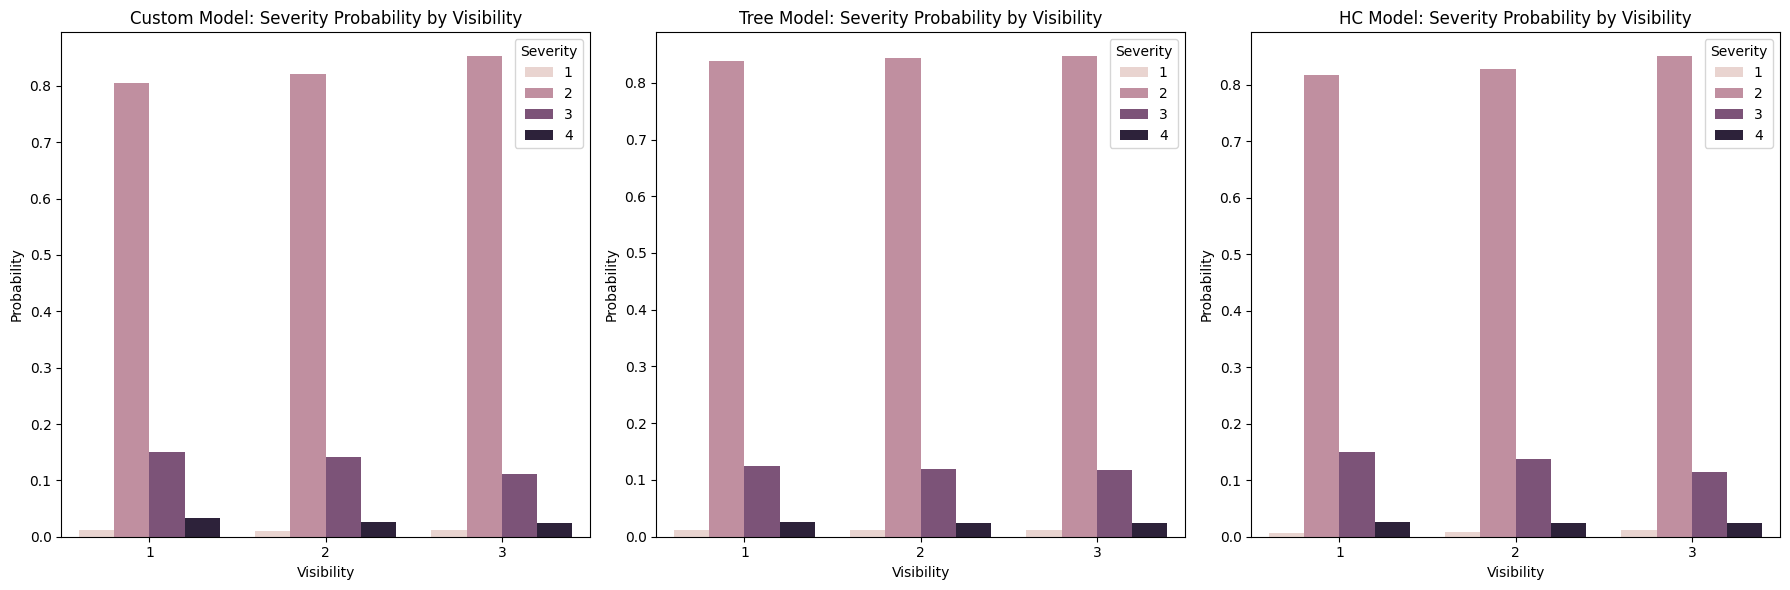

In [27]:
# Define the range of visibility to analyze
visibility_range = [1, 2, 3]  # Corresponding to Low, Moderate, High visibility

# Initialize dictionaries to store results for custom, tree, and hc models
severity_probs_custom_visibility = {}
severity_probs_tree_visibility = {}
severity_probs_hc_visibility = {}

# Perform the query for each visibility level in the range
for visibility in visibility_range:
    evidence = {'Visibility(mi)': visibility}
    
    # Query the custom model
    query_result_custom = infer_custom.query(variables=['Severity'], evidence=evidence)
    severity_probs_custom_visibility[visibility] = query_result_custom.values
    
    # Query the tree model
    query_result_tree = infer_tree.query(variables=['Severity'], evidence=evidence)
    severity_probs_tree_visibility[visibility] = query_result_tree.values
    
    # Query the hc model
    query_result_hc = infer_hc.query(variables=['Severity'], evidence=evidence)
    severity_probs_hc_visibility[visibility] = query_result_hc.values

# Prepare data for seaborn for the three models
plot_data_custom_visibility = []
plot_data_tree_visibility = []
plot_data_hc_visibility = []

for visibility, probs in severity_probs_custom_visibility.items():
    for severity, prob in zip([1, 2, 3, 4], probs):
        plot_data_custom_visibility.append({'Visibility': visibility, 'Severity': severity, 'Probability': prob})

for visibility, probs in severity_probs_tree_visibility.items():
    for severity, prob in zip([1, 2, 3, 4], probs):
        plot_data_tree_visibility.append({'Visibility': visibility, 'Severity': severity, 'Probability': prob})
        
for visibility, probs in severity_probs_hc_visibility.items():
    for severity, prob in zip([1, 2, 3, 4], probs):
        plot_data_hc_visibility.append({'Visibility': visibility, 'Severity': severity, 'Probability': prob})

plot_df_custom_visibility = pd.DataFrame(plot_data_custom_visibility)
plot_df_tree_visibility = pd.DataFrame(plot_data_tree_visibility)
plot_df_hc_visibility = pd.DataFrame(plot_data_hc_visibility)

# Plot using seaborn with three subplots
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(data=plot_df_custom_visibility, x='Visibility', y='Probability', hue='Severity', ci=None)
plt.title("Custom Model: Severity Probability by Visibility")
plt.xlabel("Visibility")
plt.ylabel("Probability")
plt.legend(title="Severity")

plt.subplot(1, 3, 2)
sns.barplot(data=plot_df_tree_visibility, x='Visibility', y='Probability', hue='Severity', ci=None)
plt.title("Tree Model: Severity Probability by Visibility")
plt.xlabel("Visibility")
plt.ylabel("Probability")
plt.legend(title="Severity")

plt.subplot(1, 3, 3)
sns.barplot(data=plot_df_hc_visibility, x='Visibility', y='Probability', hue='Severity', ci=None)
plt.title("HC Model: Severity Probability by Visibility")
plt.xlabel("Visibility")
plt.ylabel("Probability")
plt.legend(title="Severity")

plt.tight_layout()
plt.show()

### QUERY 3

"Is it more dangerous to drive at night?"

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

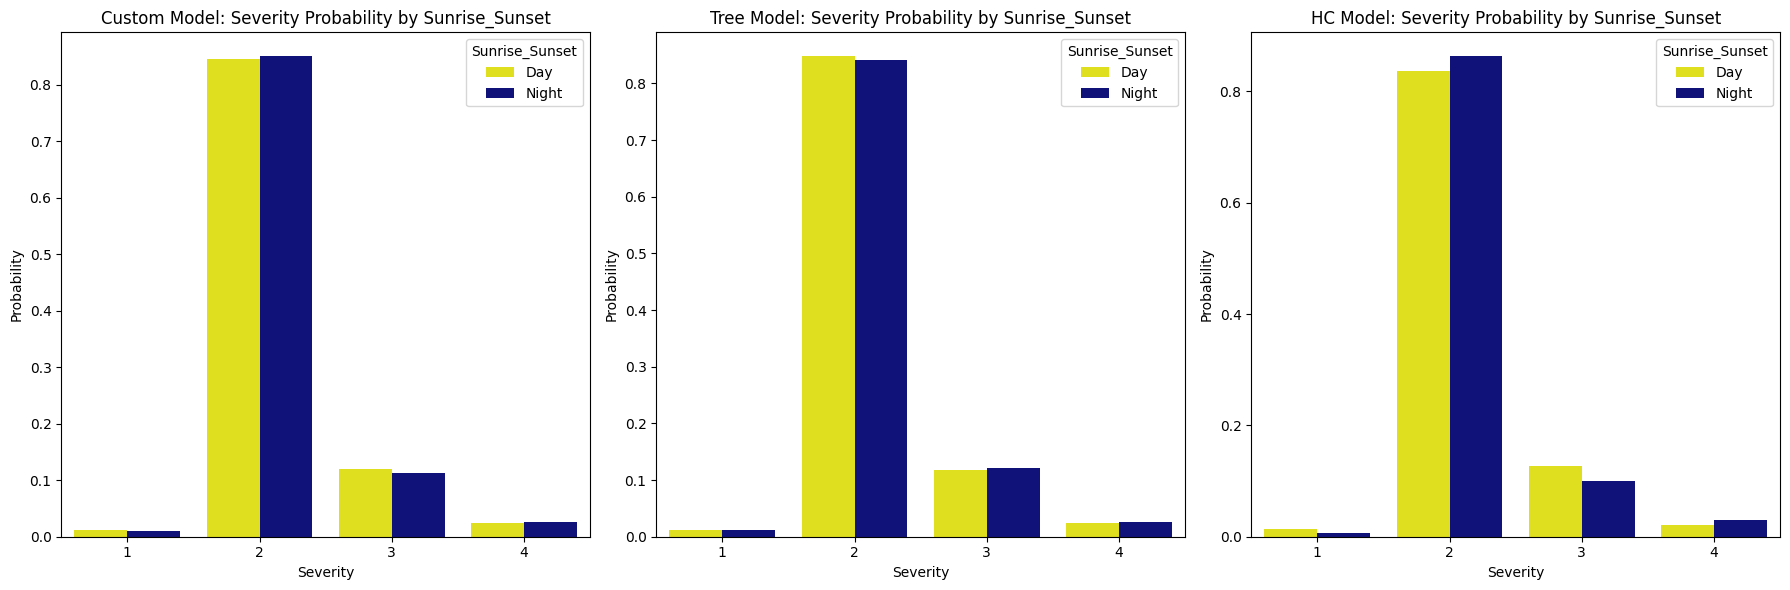

In [28]:
# Define the range of sunrise_sunset to analyze
sunrise_sunset_range = ['Day', 'Night']

# Initialize dictionaries to store results for custom, tree, and hc models
severity_probs_custom_sunrise_sunset = {}
severity_probs_tree_sunrise_sunset = {}
severity_probs_hc_sunrise_sunset = {}

# Perform the query for each sunrise_sunset value in the range
for time in sunrise_sunset_range:
    evidence = {'Sunrise_Sunset': time}
    
    # Query the custom model
    query_result_custom = infer_custom.query(variables=['Severity'], evidence=evidence)
    severity_probs_custom_sunrise_sunset[time] = query_result_custom.values
    
    # Query the tree model
    query_result_tree = infer_tree.query(variables=['Severity'], evidence=evidence)
    severity_probs_tree_sunrise_sunset[time] = query_result_tree.values
    
    # Query the hc model
    query_result_hc = infer_hc.query(variables=['Severity'], evidence=evidence)
    severity_probs_hc_sunrise_sunset[time] = query_result_hc.values

# Prepare data for seaborn for all models
plot_data_custom_sunrise_sunset = []
plot_data_tree_sunrise_sunset = []
plot_data_hc_sunrise_sunset = []

for time, probs in severity_probs_custom_sunrise_sunset.items():
    for severity, prob in zip([1, 2, 3, 4], probs):
        plot_data_custom_sunrise_sunset.append({
            'Sunrise_Sunset': time, 'Severity': severity, 'Probability': prob
        })

for time, probs in severity_probs_tree_sunrise_sunset.items():
    for severity, prob in zip([1, 2, 3, 4], probs):
        plot_data_tree_sunrise_sunset.append({
            'Sunrise_Sunset': time, 'Severity': severity, 'Probability': prob
        })

for time, probs in severity_probs_hc_sunrise_sunset.items():
    for severity, prob in zip([1, 2, 3, 4], probs):
        plot_data_hc_sunrise_sunset.append({
            'Sunrise_Sunset': time, 'Severity': severity, 'Probability': prob
        })

plot_df_custom_sunrise_sunset = pd.DataFrame(plot_data_custom_sunrise_sunset)
plot_df_tree_sunrise_sunset = pd.DataFrame(plot_data_tree_sunrise_sunset)
plot_df_hc_sunrise_sunset = pd.DataFrame(plot_data_hc_sunrise_sunset)

# Plot using seaborn with three subplots
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(data=plot_df_custom_sunrise_sunset, x='Severity', y='Probability', hue='Sunrise_Sunset', 
            ci=None, palette={'Day': 'yellow', 'Night': 'darkblue'})
plt.title("Custom Model: Severity Probability by Sunrise_Sunset")
plt.xlabel("Severity")
plt.ylabel("Probability")
plt.legend(title="Sunrise_Sunset")

plt.subplot(1, 3, 2)
sns.barplot(data=plot_df_tree_sunrise_sunset, x='Severity', y='Probability', hue='Sunrise_Sunset', 
            ci=None, palette={'Day': 'yellow', 'Night': 'darkblue'})
plt.title("Tree Model: Severity Probability by Sunrise_Sunset")
plt.xlabel("Severity")
plt.ylabel("Probability")
plt.legend(title="Sunrise_Sunset")

plt.subplot(1, 3, 3)
sns.barplot(data=plot_df_hc_sunrise_sunset, x='Severity', y='Probability', hue='Sunrise_Sunset', 
            ci=None, palette={'Day': 'yellow', 'Night': 'darkblue'})
plt.title("HC Model: Severity Probability by Sunrise_Sunset")
plt.xlabel("Severity")
plt.ylabel("Probability")
plt.legend(title="Sunrise_Sunset")

plt.tight_layout()
plt.show()

### QUERY 4

"Is it more dangerous to travel in Missisipi or Massachusetts?"

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

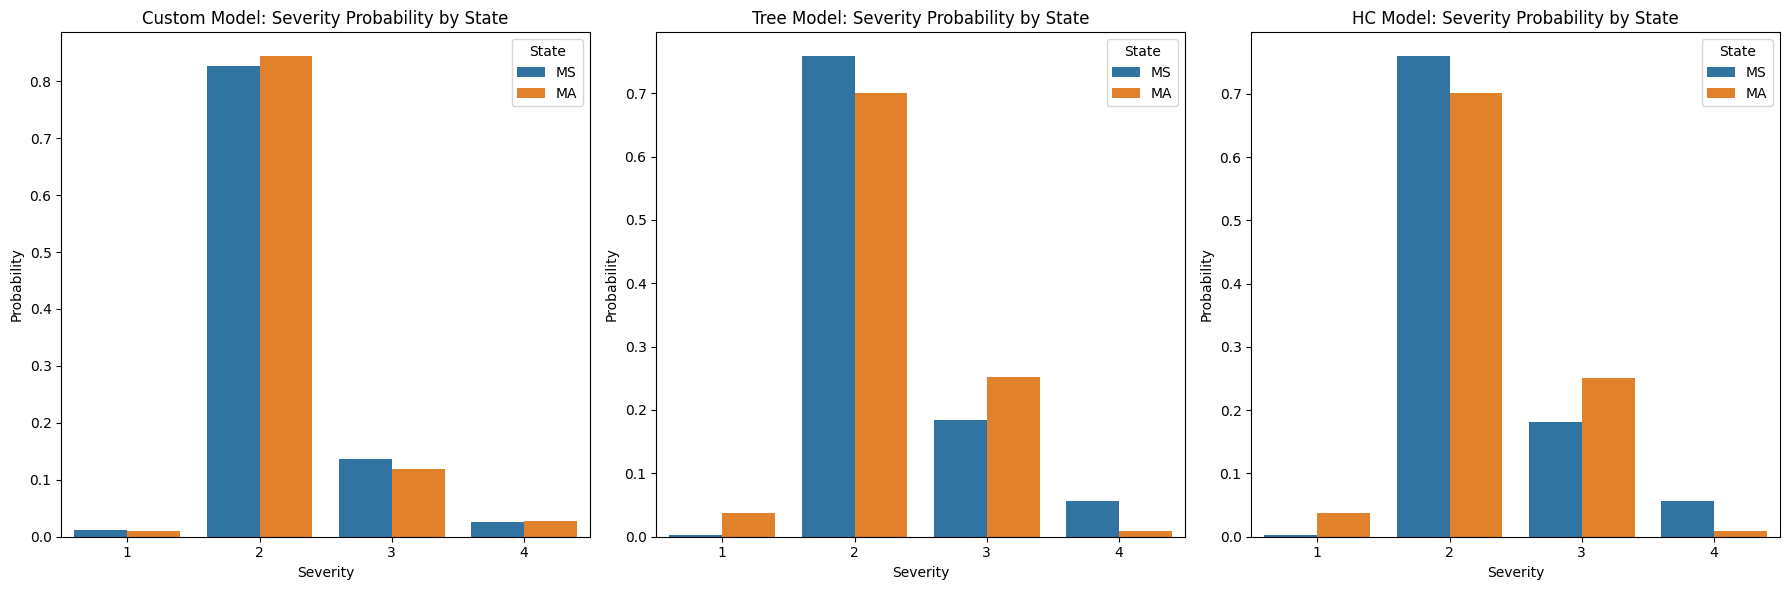

In [29]:
# Define the range of states to analyze
states = ['MS', 'MA']

# Initialize dictionaries to store results
severity_probs_custom_state = {}
severity_probs_tree_state = {}
severity_probs_hc_state = {}

# Perform the query for each state in the range
for state in states:
    evidence = {'State': state}
    
    # Query the custom model
    query_result_custom = infer_custom.query(variables=['Severity'], evidence=evidence)
    severity_probs_custom_state[state] = query_result_custom.values
    
    # Query the tree model
    query_result_tree = infer_tree.query(variables=['Severity'], evidence=evidence)
    severity_probs_tree_state[state] = query_result_tree.values

    # Query the hc model
    query_result_hc = infer_hc.query(variables=['Severity'], evidence=evidence)
    severity_probs_hc_state[state] = query_result_hc.values

# Prepare data for seaborn
plot_data_custom_state = []
plot_data_tree_state = []
plot_data_hc_state = []

for state, probs in severity_probs_custom_state.items():
    for severity, prob in zip([1, 2, 3, 4], probs):
        plot_data_custom_state.append({'State': state, 'Severity': severity, 'Probability': prob})

for state, probs in severity_probs_tree_state.items():
    for severity, prob in zip([1, 2, 3, 4], probs):
        plot_data_tree_state.append({'State': state, 'Severity': severity, 'Probability': prob})

for state, probs in severity_probs_hc_state.items():
    for severity, prob in zip([1, 2, 3, 4], probs):
        plot_data_hc_state.append({'State': state, 'Severity': severity, 'Probability': prob})

plot_df_custom_state = pd.DataFrame(plot_data_custom_state)
plot_df_tree_state = pd.DataFrame(plot_data_tree_state)
plot_df_hc_state = pd.DataFrame(plot_data_hc_state)

# Plot using seaborn with three subplots for custom, tree, and hc models
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(data=plot_df_custom_state, x='Severity', y='Probability', hue='State', ci=None)
plt.title("Custom Model: Severity Probability by State")
plt.xlabel("Severity")
plt.ylabel("Probability")
plt.legend(title="State")

plt.subplot(1, 3, 2)
sns.barplot(data=plot_df_tree_state, x='Severity', y='Probability', hue='State', ci=None)
plt.title("Tree Model: Severity Probability by State")
plt.xlabel("Severity")
plt.ylabel("Probability")
plt.legend(title="State")

plt.subplot(1, 3, 3)
sns.barplot(data=plot_df_hc_state, x='Severity', y='Probability', hue='State', ci=None)
plt.title("HC Model: Severity Probability by State")
plt.xlabel("Severity")
plt.ylabel("Probability")
plt.legend(title="State")

plt.tight_layout()
plt.show()

# ALTRE QUERY (DA TOGLIERE?)

Inference query result for 'Severity' using custom model:
+-------------+-----------------+
| Severity    |   phi(Severity) |
+=============+=================+
| Severity(1) |          0.0613 |
+-------------+-----------------+
| Severity(2) |          0.6980 |
+-------------+-----------------+
| Severity(3) |          0.1737 |
+-------------+-----------------+
| Severity(4) |          0.0670 |
+-------------+-----------------+
Inference query result for 'Severity' using tree model:
+-------------+-----------------+
| Severity    |   phi(Severity) |
+=============+=================+
| Severity(1) |          0.0133 |
+-------------+-----------------+
| Severity(2) |          0.8569 |
+-------------+-----------------+
| Severity(3) |          0.1099 |
+-------------+-----------------+
| Severity(4) |          0.0200 |
+-------------+-----------------+


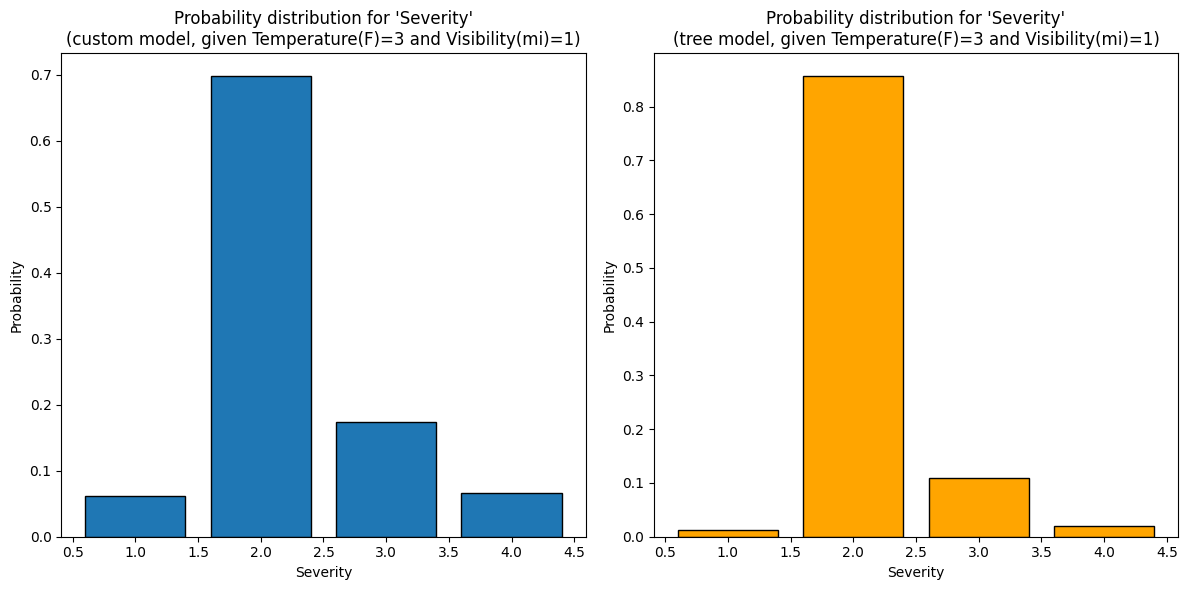

In [23]:

# Perform the query: condition on Temperature(F)=3 and Visibility(mi)=1
query_result_custom = infer_custom.query(variables=['Severity'], evidence={'Temperature(F)': 3, 'Visibility(mi)': 1})
print("Inference query result for 'Severity' using custom model:")
print(query_result_custom)

query_result_tree = infer_tree.query(variables=['Severity'], evidence={'Temperature(F)': 3, 'Visibility(mi)': 1})
print("Inference query result for 'Severity' using tree model:")
print(query_result_tree)

# Extract states and probabilities for custom model
states_custom = query_result_custom.state_names['Severity']
probabilities_custom = query_result_custom.values

# Extract states and probabilities for tree model
states_tree = query_result_tree.state_names['Severity']
probabilities_tree = query_result_tree.values

# Create bar charts to visualize the distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(states_custom, probabilities_custom, edgecolor='black')
plt.xlabel("Severity")
plt.ylabel("Probability")
plt.title("Probability distribution for 'Severity'\n(custom model, given Temperature(F)=3 and Visibility(mi)=1)")

plt.subplot(1, 2, 2)
plt.bar(states_tree, probabilities_tree, color='orange', edgecolor='black')
plt.xlabel("Severity")
plt.ylabel("Probability")
plt.title("Probability distribution for 'Severity'\n(tree model, given Temperature(F)=3 and Visibility(mi)=1)")

plt.tight_layout()
plt.show()


Qual è la distribuzione di probabilità per la gravità dell'incidente (Severity) dato che:

la temperatura è alta (Temperature(F) = 3),
la visibilità è bassa (Visibility(mi) = 1),
la velocità del vento è elevata (Wind_Speed(mph) = 3)
e le precipitazioni sono elevate (Precipitation(in) = 3)?

In [24]:
# Ensure the tree model is fitted to the data
tree_model.fit(data)

# Create inference objects for both models
infer_custom = infer  # already defined from custom_model
infer_tree = VariableElimination(tree_model)

# Define the evidence
evidence = {'Temperature(F)': 3, 'Visibility(mi)': 1, 'Wind_Speed(mph)': 3, 'Precipitation(in)': 3}

# Query both models for the distribution of 'Severity'
custom_result = infer_custom.query(variables=['Severity'], evidence=evidence)
tree_result = infer_tree.query(variables=['Severity'], evidence=evidence)

# Extract states and probabilities
states = custom_result.state_names['Severity']
probs_custom = custom_result.values
probs_tree = tree_result.values

# Plot results side by side for comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(states, probs_custom, edgecolor='black')
plt.xlabel("Severity")
plt.ylabel("Probability")
plt.title("Custom Model")

plt.subplot(1, 2, 2)
plt.bar(states, probs_tree, color='orange', edgecolor='black')
plt.xlabel("Severity")
plt.ylabel("Probability")
plt.title("Tree Model")

plt.suptitle("Comparison of 'Severity' Distribution\n(for Temperature(F)=3, Visibility(mi)=1,\nWind_Speed(mph)=3, Precipitation(in)=3)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


NameError: name 'infer' is not defined

In [ ]:
# Define the evidence for Mississippi and New York
evidence_mississippi = {'State': 'MS'}
evidence_new_york = {'State': 'NY'}

# Perform the query for Mississippi
query_result_mississippi = infer.query(variables=['Severity'], evidence=evidence_mississippi)
print("Inference query result for 'Severity' in Mississippi:")
print(query_result_mississippi)

# Perform the query for New York
query_result_new_york = infer.query(variables=['Severity'], evidence=evidence_new_york)
print("Inference query result for 'Severity' in New York:")
print(query_result_new_york)

# Extract states and probabilities for Mississippi
states_mississippi = query_result_mississippi.state_names['Severity']
probabilities_mississippi = query_result_mississippi.values

# Extract states and probabilities for New York
states_new_york = query_result_new_york.state_names['Severity']
probabilities_new_york = query_result_new_york.values

# Create the bar chart to visualize the distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(states_mississippi, probabilities_mississippi, edgecolor='black')
plt.xlabel("Severity")
plt.ylabel("Probability")
plt.title("Probability distribution for 'Severity' in Mississippi")

plt.subplot(1, 2, 2)
plt.bar(states_new_york, probabilities_new_york, color='orange', edgecolor='black')
plt.xlabel("Severity")
plt.ylabel("Probability")
plt.title("Probability distribution for 'Severity' in New York")

plt.suptitle("Comparison of 'Severity' distribution\nbetween Mississippi and New York")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()